# Import Modules

In [1]:
import pandas as pd
import numpy as np
import emoji
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import pipeline
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Model
from keras.layers import SimpleRNN, Activation, Dense, Dropout, Input, Embedding, LSTM
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/student/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Import Data

In [2]:
df = pd.read_csv('tweets.csv')

df

/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/3887519479.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tweets.csv')


,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Bohmle,"#GPT4 for FREE. \nNo its not a clickbait, @Qol...",Carkingga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,AI enthusiast,2019-07-03 03:44:41+00:00,60.0,349.0,611,False,2023-05-17 18:11:12+00:00,"['GPT4', 'ChatGPT4']",Twitter Web App,NaN,NaN
2,Dan Bruno AI,ChatGPT Thinks These 5 Crypto Coins Will Explo...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
3,Georgiana Comsa,New: @JWVance's post about 5 #startups (includ...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
4,Bitone Great,🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation:...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
...,...,...,...,...,...,...,...,...,...,...,...,...
3412806,(I)(AM)(T)(MOYO),"Levels🙏🙏🙏,so happy for the chatGPT team for co...",Satoshi Island,Blockchain Enthusiast || Philanthropist || a S...,2013-12-07 16:38:30+00:00,3419.0,4994.0,16659,False,2022-12-05 17:10:31+00:00,NaN,Twitter for Android
3412807,Green,Iterating back-and-forth with tools like #Chat...,🍁,NaN,2022-12-03 12:49:13+00:00,3.0,33.0,3,False,2022-12-05 17:09:22+00:00,['ChatGPT'],Twitter Web App
3412808,Gabriel Furstenheim,Russel vs ChatGPT. It's also funny that it tak...,NaN,Mathematician and Developer @Amazon. Previousl...,2016-07-09 21:08:52+00:00,80.0,34.0,169,False,2022-12-05 17:09:04+00:00,['ChatGPT'],Twitter for Android
3412809,Devang,Was just wondering is there any difference bet...,United States,"passionate by nature, software developer by pr...",2015-05-19 03:17:06+00:00,15.0,86.0,307,False,2022-12-05 17:08:44+00:00,"['ChatGPT', 'GPT3']",Twitter for Android


# Exploratory Data Analysis

In [3]:
print('Rows              :',df.shape[0])
print('Columns           :',df.shape[1])
print('\nFeatures        :\n',df.columns)
print('\nMissing values  :',df.isna().sum().values.sum())
print('\nUnique values   :',df.nunique())

Rows              : 3412811
Columns           : 12

Features        :
 Index(['user_name', 'text', 'user_location', 'user_description',
       'user_created', 'user_followers', 'user_friends', 'user_favourites',
       'user_verified', 'date', 'hashtags', 'source'],
      dtype='object')

Missing values  : 32106521

Unique values   : user_name           183646
text                474943
user_location        41866
user_description    187179
user_created        185757
user_followers       43556
user_friends         18652
user_favourites      51271
user_verified           62
date                459640
hashtags            110543
source                1230
dtype: int64


# Remove Duplicate Rows

In [4]:
def remove_duplicate_rows(df):
    duplicate_rows = df.duplicated()
    df = df[~duplicate_rows]
    df = df.reset_index(drop=True)
    
    return df

# Remove Missing Values

In [5]:
def remove_missing_values(df):
    df = df.dropna()
    df = df.reset_index(drop=True)
    return df

# Normalize/Clean the Text

In [6]:
def normalize_text(text):
    for i in range(len(text)):
        text[i] = text[i].lower()              #lower case all text
        translator = str.maketrans("", "", string.punctuation)      #get punctuations
        text[i] = text[i].translate(translator)                #remove punctuations'
        text[i] = emoji.demojize(text[i])                     #convert emojis to text
        text[i] = text[i].replace('\r', ' ').replace('\n', ' ')
    
    return text

# Stop Word Removal

In [7]:
def remove_stopwords(text):
    for i in range(len(text)):
        stop_words = set(stopwords.words('english'))
        words = text[i].split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        text[i] = ' '.join(filtered_words)
        
    return text

# Stemming

In [8]:
def stemming(text):
    stemmer = PorterStemmer()
    
    for i in range(len(text)):
        words = word_tokenize(text[i])
        stemmed_words = [stemmer.stem(word) for word in words]
        text[i] = ' '.join(stemmed_words)
        
    return text

# Remove Links

In [9]:
def remove_links(text):
    for i in range(len(text)):
        text[i] = re.sub(r'http\S+', '', text[i])
        text[i] = re.sub(r'www\S+', '', text[i])
        text[i] = re.sub(r'[^\w\s]', '', text[i])
    
    return text

# Remove Special Characters

In [10]:
def remove_special_characters(text):
    for i in range(len(text)):
        text[i] = re.sub('[^a-zA-z0-9\s]', '', text[i])
    
    return text

# N Gram Analysis

In [27]:
def n_grams(n, text):
    ngrams_list = []
    
    for i in text:
        words = i.split(' ')
        for i in range(len(words) - n + 1):
            ngram = ' '.join(words[i:i+n])
            ngrams_list.append(ngram)
    
    return ngrams_list

def n_gram_count(ngram):
    counts = {}
    
    for i in ngram:
        counts[i] = ngram.count(i)
        
    return counts

# Word Cloud Generation

In [33]:
def wordcloud(text):
    words = []
    
    for i in text:
        words.extend(i.split(' '))
        
    plt.figure(figsize=(16,13))
    wc=WordCloud(background_color='white',colormap='Set2',max_words=1000,max_font_size=200,width=1600,height=800)
    wc.generate(" ".join(words))
    plt.title('Most discussed terms',fontsize=20)
    plt.imshow(wc.recolor(colormap='Set2',random_state=17),alpha=0.98,interpolation='bilinear')
    plt.axis('off')
    plt.savefig('Word_Cloud_2020041.jpg')

# Sentiment Analysis Text Blob and RoBERTa

In [36]:
def textblob(text):
    polarities = []

    for i in text:
        blob = TextBlob(i)

        sentiment = blob.sentiment

        polarities.append(sentiment.polarity)    

    return polarities

def roberta(text):
    sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
    sentiments = []
    for i in text:
        sentiments.append(sentiment_analysis(i))

    return sentiments

# Feature Engineering

In [14]:
# Calculate length of sentences

def get_sentence_length(text):
    sentence_length = {}
    
    for i in range(len(text)):
        sentence_length[str(i)] = len(text[i])
        
    return sentence_length      #returns length of sentences w.r.t letters

def word_count(text):
    word_counts = {}
    
    for i in range(len(text)):
        word_counts[str(i)] = len(text[i].split(' '))
        
    return word_counts

def space_count(text):
    space_counts = {}
    
    for i in range(len(text)):
        space_counts[str(i)] = text[i].count(' ')
        
    return space_counts

def verb_count(text):
    pos_tags_count = {}
    
    for i in range(len(text)):
        tokens = nltk.word_tokenize(text[i])
        pos_tags = nltk.pos_tag(tokens)
        
        pos_counts = Counter(tag for word, tag in pos_tags)
        
        pos_tags_count[str(i)] = pos_counts
        
    return pos_tags_count

def count_words_with_A_start(text):
    counts = {}
    
    for i in range(len(text)):
        words = text[i].split(' ')
        
        words_A = [word for word in words if word[0] == 'A']
        
        counts[str(i)] = len(words_A)
        
    return counts

# Vectorization

In [15]:
def count_vectorizer(text):
    count_vect = CountVectorizer()
    
    X = vectorizer.fit_transform(text)
    
    return X

def tfidf_vectorizer(text):
    vectorizer = TfidfVectorizer()
    
    X = vectorizer.fit_transform(text)
    
    return X

def word2vec(text):
    sentences = []
    
    for i in text:
        sentences.append(i.split(' '))
        
    model = Word2Vec(sentences, min_count=1)  # Train the Word2Vec model on the sentences

    # You can now use the trained model to get word embeddings
    text_embedding = model.wv['apple']
    
    return text_embedding

# Feature Selection

In [16]:
def correlations(df):
    correlation = df.corrwith(df['labels'])
    
    return correlation

def info_gain(df):
    # Calculate the information gain for each feature
    information_gains = mutual_info_classif(df[~df['labels']], df['labels'])
    
    return information_gains

# RNN Model

In [17]:
def RNNmodel():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(32)(layer)
    layer = Dense(256,name='FC1',activation='relu')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

# Machine Learning Models

In [18]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Calculate the evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'weighted')
    recall = recall_score(y_test, y_pred, average = 'weighted')
    f1 = f1_score(y_test, y_pred, average = 'weighted')

    # Print the evaluation metrics
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1)

# Main

In [19]:
df = remove_duplicate_rows(df)

df

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Bohmle,"#GPT4 for FREE. \nNo its not a clickbait, @Qol...",Carkingga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,AI enthusiast,2019-07-03 03:44:41+00:00,60.0,349.0,611,False,2023-05-17 18:11:12+00:00,"['GPT4', 'ChatGPT4']",Twitter Web App,NaN,NaN
2,Dan Bruno AI,ChatGPT Thinks These 5 Crypto Coins Will Explo...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
3,Georgiana Comsa,New: @JWVance's post about 5 #startups (includ...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
4,Bitone Great,🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation:...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
...,...,...,...,...,...,...,...,...,...,...,...,...
484385,(I)(AM)(T)(MOYO),"Levels🙏🙏🙏,so happy for the chatGPT team for co...",Satoshi Island,Blockchain Enthusiast || Philanthropist || a S...,2013-12-07 16:38:30+00:00,3419.0,4994.0,16659,False,2022-12-05 17:10:31+00:00,NaN,Twitter for Android
484386,Green,Iterating back-and-forth with tools like #Chat...,🍁,NaN,2022-12-03 12:49:13+00:00,3.0,33.0,3,False,2022-12-05 17:09:22+00:00,['ChatGPT'],Twitter Web App
484387,Gabriel Furstenheim,Russel vs ChatGPT. It's also funny that it tak...,NaN,Mathematician and Developer @Amazon. Previousl...,2016-07-09 21:08:52+00:00,80.0,34.0,169,False,2022-12-05 17:09:04+00:00,['ChatGPT'],Twitter for Android
484388,Devang,Was just wondering is there any difference bet...,United States,"passionate by nature, software developer by pr...",2015-05-19 03:17:06+00:00,15.0,86.0,307,False,2022-12-05 17:08:44+00:00,"['ChatGPT', 'GPT3']",Twitter for Android


In [20]:
df = remove_missing_values(df)

df

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Dan Bruno AI,ChatGPT Thinks These 5 Crypto Coins Will Explo...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
1,Georgiana Comsa,New: @JWVance's post about 5 #startups (includ...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
2,Bitone Great,🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation:...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
3,ScrapeLogo: acquired by RiteKit in 2015,Video : Show a company's logo based on the web...,"Prague, Czech Republic",Test RiteKit #RESTAPI solutions in demo page. ...,2015-01-31 04:13:07+00:00,176.0,54.0,274,False,2023-05-17 18:09:04+00:00,['Short'],RiteKit App
4,vigilance.eth™️ 0x676D | 🇨🇦🇮🇪🇬🇧🇨🇵,I just used my #CerberusGPT HologeneticsLab an...,"London, ON",🇨🇦 #blockchain #ai #ChatGPT #promptcraft 🤖wiza...,2021-01-30 21:03:36+00:00,123.0,299.0,8938,False,2023-05-17 18:09:00+00:00,['CerberusGPT'],Twitter Web App
...,...,...,...,...,...,...,...,...,...,...,...,...
258895,Abhas Tandon,These opinions are not mine. The above critici...,India,Yet another Software Engineer. #JavaScript #no...,2009-06-06 15:27:28+00:00,3549.0,1318.0,1220,False,2022-12-05 17:12:28+00:00,['ChatGPT'],Twitter Web App
258896,Rλan Tomczik,At least #ChatGPT can admit when it makes mist...,"Minneapolis, MN","Functional Programming, Music Theory, Data Eng...",2011-12-10 18:31:35+00:00,279.0,2179.0,6335,False,2022-12-05 17:12:10+00:00,"['ChatGPT', 'MusicTheory']",Twitter Web App
258897,Nick Perkins • Hebrews 13:8 • Development Manager,Ok now @OpenAI is just showing off. lol #ChatG...,"Raleigh, North Carolina, USA","A proud Dad of 3, husband, Dev manager, iOS en...",2013-12-04 17:12:00+00:00,164.0,326.0,6317,False,2022-12-05 17:11:37+00:00,['ChatGPT'],Twitter Web App
258898,Devang,Was just wondering is there any difference bet...,United States,"passionate by nature, software developer by pr...",2015-05-19 03:17:06+00:00,15.0,86.0,307,False,2022-12-05 17:08:44+00:00,"['ChatGPT', 'GPT3']",Twitter for Android


In [21]:
df = df[:1000]

df['text'] = normalize_text(df['text'])

df

/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/3366246368.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[i] = text[i].lower()              #lower case all text
/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/3366246368.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[i] = text[i].translate(translator)                #remove punctuations'
/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/3366246368.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Dan Bruno AI,chatgpt thinks these 5 crypto coins will explo...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
1,Georgiana Comsa,new jwvances post about 5 startups including v...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
2,Bitone Great,:police_car_light:get out:police_car_light: :m...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
3,ScrapeLogo: acquired by RiteKit in 2015,video show a companys logo based on the websi...,"Prague, Czech Republic",Test RiteKit #RESTAPI solutions in demo page. ...,2015-01-31 04:13:07+00:00,176.0,54.0,274,False,2023-05-17 18:09:04+00:00,['Short'],RiteKit App
4,vigilance.eth™️ 0x676D | 🇨🇦🇮🇪🇬🇧🇨🇵,i just used my cerberusgpt hologeneticslab and...,"London, ON",🇨🇦 #blockchain #ai #ChatGPT #promptcraft 🤖wiza...,2021-01-30 21:03:36+00:00,123.0,299.0,8938,False,2023-05-17 18:09:00+00:00,['CerberusGPT'],Twitter Web App
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bitone Great,:police_car_light:short greed:police_car_light...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:25:19+00:00,"['Binance', 'Short', 'NKNBUSD']",rsi1
996,Firas M.,ai risks and security explained chatgpt aiass...,Toronto,Senior IT Business Consultant at Fraxnet. Regi...,2009-02-08 08:32:00+00:00,61.0,563.0,261,False,2023-05-17 10:25:11+00:00,"['chatGPT', 'Ai_assisstants', 'ai_attack']",Twitter Web App
997,Bitone Great,:chart_decreasing:sell:chart_decreasing: :fire...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:24:14+00:00,"['Sell', 'Bybit', 'Short', 'CTSIUSDT']",rsi1
998,Pratik Vasu,starting today chatgpt 4 is officially my chie...,pratik.vivrelavie@gmail.com,"21 y/o founder funded at 19, Tech, Marketing, ...",2020-03-31 12:20:17+00:00,42.0,82.0,2266,False,2023-05-17 10:22:46+00:00,"['ChatGPT', 'chatgpt4', 'AI']",Twitter for Android


In [22]:
df['text'] = remove_stopwords(df['text'])

df

/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/2175805163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[i] = ' '.join(filtered_words)
/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/2318519918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = remove_stopwords(df['text'])


,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Dan Bruno AI,chatgpt thinks 5 crypto coins explode year yah...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
1,Georgiana Comsa,new jwvances post 5 startups including vcinity...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
2,Bitone Great,:police_car_light:get out:police_car_light: :m...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
3,ScrapeLogo: acquired by RiteKit in 2015,video show companys logo based website domain ...,"Prague, Czech Republic",Test RiteKit #RESTAPI solutions in demo page. ...,2015-01-31 04:13:07+00:00,176.0,54.0,274,False,2023-05-17 18:09:04+00:00,['Short'],RiteKit App
4,vigilance.eth™️ 0x676D | 🇨🇦🇮🇪🇬🇧🇨🇵,used cerberusgpt hologeneticslab simulated hol...,"London, ON",🇨🇦 #blockchain #ai #ChatGPT #promptcraft 🤖wiza...,2021-01-30 21:03:36+00:00,123.0,299.0,8938,False,2023-05-17 18:09:00+00:00,['CerberusGPT'],Twitter Web App
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bitone Great,:police_car_light:short greed:police_car_light...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:25:19+00:00,"['Binance', 'Short', 'NKNBUSD']",rsi1
996,Firas M.,ai risks security explained chatgpt aiassissta...,Toronto,Senior IT Business Consultant at Fraxnet. Regi...,2009-02-08 08:32:00+00:00,61.0,563.0,261,False,2023-05-17 10:25:11+00:00,"['chatGPT', 'Ai_assisstants', 'ai_attack']",Twitter Web App
997,Bitone Great,:chart_decreasing:sell:chart_decreasing: :fire...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:24:14+00:00,"['Sell', 'Bybit', 'Short', 'CTSIUSDT']",rsi1
998,Pratik Vasu,starting today chatgpt 4 officially chief mark...,pratik.vivrelavie@gmail.com,"21 y/o founder funded at 19, Tech, Marketing, ...",2020-03-31 12:20:17+00:00,42.0,82.0,2266,False,2023-05-17 10:22:46+00:00,"['ChatGPT', 'chatgpt4', 'AI']",Twitter for Android


In [23]:
df['text'] = stemming(df['text'])

df

/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/1866603613.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[i] = ' '.join(stemmed_words)
/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/402261284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = stemming(df['text'])


,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Dan Bruno AI,chatgpt think 5 crypto coin explod year yahoo ...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
1,Georgiana Comsa,new jwvanc post 5 startup includ vcinityinc 1s...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
2,Bitone Great,: police_car_light : get out : police_car_ligh...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
3,ScrapeLogo: acquired by RiteKit in 2015,video show compani logo base websit domain sho...,"Prague, Czech Republic",Test RiteKit #RESTAPI solutions in demo page. ...,2015-01-31 04:13:07+00:00,176.0,54.0,274,False,2023-05-17 18:09:04+00:00,['Short'],RiteKit App
4,vigilance.eth™️ 0x676D | 🇨🇦🇮🇪🇬🇧🇨🇵,use cerberusgpt hologeneticslab simul hologene...,"London, ON",🇨🇦 #blockchain #ai #ChatGPT #promptcraft 🤖wiza...,2021-01-30 21:03:36+00:00,123.0,299.0,8938,False,2023-05-17 18:09:00+00:00,['CerberusGPT'],Twitter Web App
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bitone Great,: police_car_light : short greed : police_car_...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:25:19+00:00,"['Binance', 'Short', 'NKNBUSD']",rsi1
996,Firas M.,ai risk secur explain chatgpt aiassisst aiatta...,Toronto,Senior IT Business Consultant at Fraxnet. Regi...,2009-02-08 08:32:00+00:00,61.0,563.0,261,False,2023-05-17 10:25:11+00:00,"['chatGPT', 'Ai_assisstants', 'ai_attack']",Twitter Web App
997,Bitone Great,: chart_decreas : sell : chart_decreas : : fir...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:24:14+00:00,"['Sell', 'Bybit', 'Short', 'CTSIUSDT']",rsi1
998,Pratik Vasu,start today chatgpt 4 offici chief market offi...,pratik.vivrelavie@gmail.com,"21 y/o founder funded at 19, Tech, Marketing, ...",2020-03-31 12:20:17+00:00,42.0,82.0,2266,False,2023-05-17 10:22:46+00:00,"['ChatGPT', 'chatgpt4', 'AI']",Twitter for Android


In [24]:
df['text'] = remove_links(df['text'])

df

/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/3566720583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[i] = re.sub(r'http\S+', '', text[i])
/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/3566720583.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[i] = re.sub(r'www\S+', '', text[i])
/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/3566720583.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Dan Bruno AI,chatgpt think 5 crypto coin explod year yahoo ...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
1,Georgiana Comsa,new jwvanc post 5 startup includ vcinityinc 1s...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
2,Bitone Great,police_car_light get out police_car_light ...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
3,ScrapeLogo: acquired by RiteKit in 2015,video show compani logo base websit domain sho...,"Prague, Czech Republic",Test RiteKit #RESTAPI solutions in demo page. ...,2015-01-31 04:13:07+00:00,176.0,54.0,274,False,2023-05-17 18:09:04+00:00,['Short'],RiteKit App
4,vigilance.eth™️ 0x676D | 🇨🇦🇮🇪🇬🇧🇨🇵,use cerberusgpt hologeneticslab simul hologene...,"London, ON",🇨🇦 #blockchain #ai #ChatGPT #promptcraft 🤖wiza...,2021-01-30 21:03:36+00:00,123.0,299.0,8938,False,2023-05-17 18:09:00+00:00,['CerberusGPT'],Twitter Web App
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bitone Great,police_car_light short greed police_car_lig...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:25:19+00:00,"['Binance', 'Short', 'NKNBUSD']",rsi1
996,Firas M.,ai risk secur explain chatgpt aiassisst aiatta...,Toronto,Senior IT Business Consultant at Fraxnet. Regi...,2009-02-08 08:32:00+00:00,61.0,563.0,261,False,2023-05-17 10:25:11+00:00,"['chatGPT', 'Ai_assisstants', 'ai_attack']",Twitter Web App
997,Bitone Great,chart_decreas sell chart_decreas fire rs...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:24:14+00:00,"['Sell', 'Bybit', 'Short', 'CTSIUSDT']",rsi1
998,Pratik Vasu,start today chatgpt 4 offici chief market offi...,pratik.vivrelavie@gmail.com,"21 y/o founder funded at 19, Tech, Marketing, ...",2020-03-31 12:20:17+00:00,42.0,82.0,2266,False,2023-05-17 10:22:46+00:00,"['ChatGPT', 'chatgpt4', 'AI']",Twitter for Android


In [25]:
df['text'] = remove_special_characters(df['text'])

df

/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/2048787854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text[i] = re.sub('[^a-zA-z0-9\s]', '', text[i])
/var/folders/cj/g08j8_tn54sft2dym246gf_80000gn/T/ipykernel_2187/341933619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = remove_special_characters(df['text'])


,user_name,text,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,hashtags,source
0,Dan Bruno AI,chatgpt think 5 crypto coin explod year yahoo ...,"Manchester, NH","The latest in #ChatGPT, #BARD, #Bing, and othe...",2021-05-19 01:19:32+00:00,470.0,157.0,5185,False,2023-05-17 18:11:03+00:00,"['chatgpt', 'AI', 'openAI']",dlvr.it
1,Georgiana Comsa,new jwvanc post 5 startup includ vcinityinc 1s...,Palo Alto,"Founder of Silicon Valley PR, award-winning PR...",2008-12-24 09:32:23+00:00,3864.0,1883.0,2415,False,2023-05-17 18:10:25+00:00,"['startups', 'startup50']",Twitter Web App
2,Bitone Great,police_car_light get out police_car_light ...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 18:09:39+00:00,"['Binance', 'Short', 'GHSTUSDT']",rsi1
3,ScrapeLogo: acquired by RiteKit in 2015,video show compani logo base websit domain sho...,"Prague, Czech Republic",Test RiteKit #RESTAPI solutions in demo page. ...,2015-01-31 04:13:07+00:00,176.0,54.0,274,False,2023-05-17 18:09:04+00:00,['Short'],RiteKit App
4,vigilance.eth™️ 0x676D | 🇨🇦🇮🇪🇬🇧🇨🇵,use cerberusgpt hologeneticslab simul hologene...,"London, ON",🇨🇦 #blockchain #ai #ChatGPT #promptcraft 🤖wiza...,2021-01-30 21:03:36+00:00,123.0,299.0,8938,False,2023-05-17 18:09:00+00:00,['CerberusGPT'],Twitter Web App
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Bitone Great,police_car_light short greed police_car_lig...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:25:19+00:00,"['Binance', 'Short', 'NKNBUSD']",rsi1
996,Firas M.,ai risk secur explain chatgpt aiassisst aiatta...,Toronto,Senior IT Business Consultant at Fraxnet. Regi...,2009-02-08 08:32:00+00:00,61.0,563.0,261,False,2023-05-17 10:25:11+00:00,"['chatGPT', 'Ai_assisstants', 'ai_attack']",Twitter Web App
997,Bitone Great,chart_decreas sell chart_decreas fire rs...,Hong Kong,#ChatGPT (AI) powered Free Trading Signal! \nL...,2022-11-21 04:42:18+00:00,1517.0,506.0,64,False,2023-05-17 10:24:14+00:00,"['Sell', 'Bybit', 'Short', 'CTSIUSDT']",rsi1
998,Pratik Vasu,start today chatgpt 4 offici chief market offi...,pratik.vivrelavie@gmail.com,"21 y/o founder funded at 19, Tech, Marketing, ...",2020-03-31 12:20:17+00:00,42.0,82.0,2266,False,2023-05-17 10:22:46+00:00,"['ChatGPT', 'chatgpt4', 'AI']",Twitter for Android


In [29]:
# Bi-Grams

bigrams = n_grams(2, df['text'])

bigram_counts = n_gram_count(bigrams)

bigram_counts = dict(sorted(bigram_counts.items(), key=lambda item: item[1]))
bigram_counts

{'think 5': 1,
 '5 crypto': 1,
 'crypto coin': 1,
 'coin explod': 1,
 'explod year': 1,
 'year yahoo': 1,
 'yahoo financ': 1,
 'financ chatgpt': 1,
 'new jwvanc': 1,
 'jwvanc post': 1,
 'post 5': 1,
 '5 startup': 1,
 'startup includ': 1,
 'includ vcinityinc': 1,
 'vcinityinc 1st': 1,
 '1st startup50': 1,
 'startup50 challeng': 1,
 'challeng thx': 1,
 'thx chatgpt': 1,
 'base answer': 1,
 'answer macroeconom': 1,
 'macroeconom pressur': 1,
 'pressur vc': 1,
 'vc fund': 1,
 'fund track': 1,
 'track record': 1,
 'record manag': 1,
 'manag team': 1,
 'team amp': 1,
 'amp growth': 1,
 'growth potenti': 1,
 'potenti market': 1,
 'market sector': 1,
 'ticker ghstusdt': 1,
 'ghstusdt time': 1,
 'price 0956': 1,
 '0956 ': 1,
 'chatgpt ghst': 1,
 'ghst ghst': 1,
 'ghst alphaquarktoken': 1,
 'alphaquarktoken ': 1,
 'video show': 1,
 'show compani': 1,
 'compani logo': 1,
 'logo base': 1,
 'base websit': 1,
 'websit domain': 1,
 'domain short': 1,
 ' video_camera': 1,
 'video_camera ': 1,
 ' backh

In [30]:
# Tri-Grams

trigrams = n_grams(3, df['text'])

trigram_counts = n_gram_count(trigrams)

trigram_counts = dict(sorted(trigram_counts.items(), key = lambda item: item[1]))

trigram_counts

{'chatgpt think 5': 1,
 'think 5 crypto': 1,
 '5 crypto coin': 1,
 'crypto coin explod': 1,
 'coin explod year': 1,
 'explod year yahoo': 1,
 'year yahoo financ': 1,
 'yahoo financ chatgpt': 1,
 'financ chatgpt ai': 1,
 'new jwvanc post': 1,
 'jwvanc post 5': 1,
 'post 5 startup': 1,
 '5 startup includ': 1,
 'startup includ vcinityinc': 1,
 'includ vcinityinc 1st': 1,
 'vcinityinc 1st startup50': 1,
 '1st startup50 challeng': 1,
 'startup50 challeng thx': 1,
 'challeng thx chatgpt': 1,
 'thx chatgpt base': 1,
 'chatgpt base answer': 1,
 'base answer macroeconom': 1,
 'answer macroeconom pressur': 1,
 'macroeconom pressur vc': 1,
 'pressur vc fund': 1,
 'vc fund track': 1,
 'fund track record': 1,
 'track record manag': 1,
 'record manag team': 1,
 'manag team amp': 1,
 'team amp growth': 1,
 'amp growth potenti': 1,
 'growth potenti market': 1,
 'potenti market sector': 1,
 'market sector ': 1,
 ' ticker ghstusdt': 1,
 'ticker ghstusdt time': 1,
 'ghstusdt time interv': 1,
 'last price

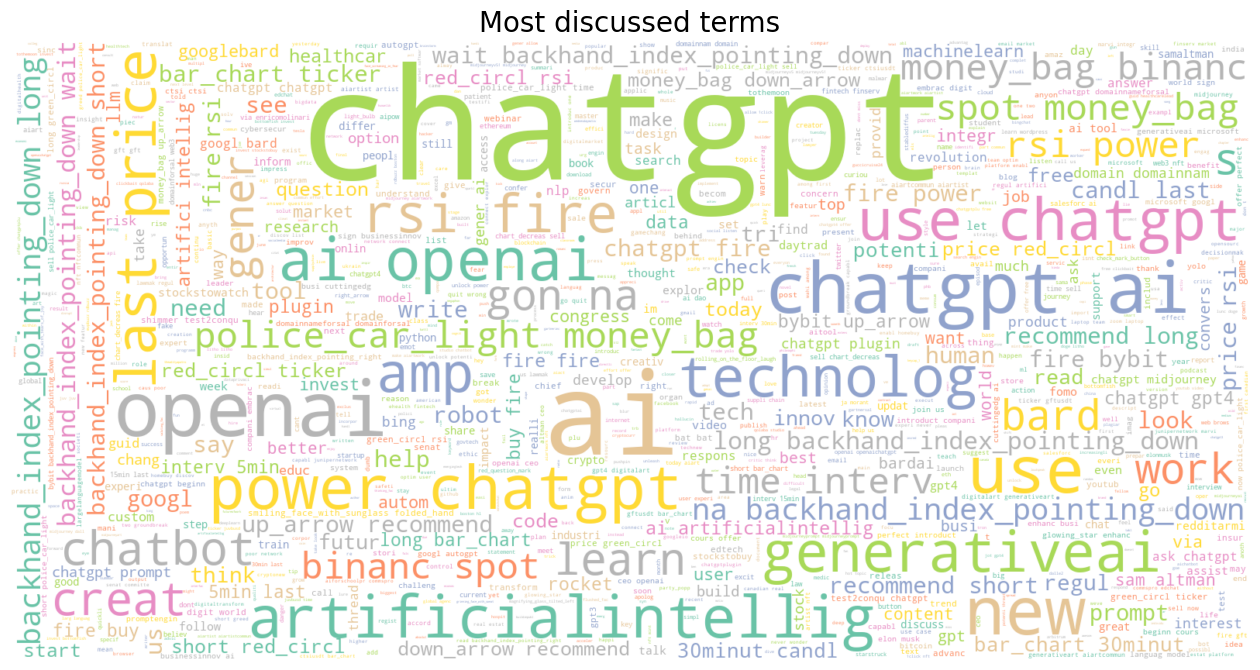

In [ ]:
wordcloud(df['text'])

In [38]:
sentiments_textblob = textblob(df['text'])

sentiments_textblob

[0.0,
 -0.33181818181818185,
 -0.0125,
 -0.4,
 -0.48333333333333334,
 -0.0125,
 0.0,
 -0.0125,
 0.0,
 -0.0125,
 0.18333333333333335,
 0.04999999999999999,
 0.0,
 0.0,
 0.0,
 -0.01,
 -0.0125,
 0.0,
 0.55,
 0.0,
 -0.5,
 0.06666666666666667,
 -0.01,
 0.0,
 0.4,
 0.0,
 -0.0375,
 0.0,
 0.0,
 0.13636363636363635,
 0.0,
 0.4,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0125,
 0.0,
 0.2,
 0.0,
 -0.4,
 0.0,
 0.10000000000000002,
 0.0,
 0.0,
 -0.0125,
 -0.01,
 0.4,
 -0.09047619047619049,
 0.475,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.4,
 0.0,
 -0.5,
 -0.3333333333333333,
 0.0,
 -0.16666666666666666,
 -0.0125,
 -0.39999999999999997,
 0.13636363636363635,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.25,
 0.0,
 0.0,
 0.0,
 -0.2,
 -0.25,
 0.274025974025974,
 0.1875,
 -0.006696428571428575,
 0.1,
 -0.125,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.05,
 0.1,
 0.0,
 0.0,
 0.0,
 -0.04242424242424244,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.34545454545454546,
 0.0,
 0.0,
 0.0,
 0.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,

In [ ]:
sentiments_roberta = roberta(df['text'])

sentiments_roberta

Downloading:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [ ]:
get_sentence_length(df['text'])

In [ ]:
word_count(df['text'])

In [ ]:
space_count(df['text'])

In [ ]:
verb_count(df['text'])

In [ ]:
count_words_with_A_start(df['text'])

In [ ]:
count_vectorizer(df['text'])

In [ ]:
tfidf_vectorizer(df['text'])

In [ ]:
word2vec(df['text'])